In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from fastai.callbacks.hooks import *
# torch.cuda.set_device(1)
import skimage.io as io
import tqdm
import os
from fastai.vision.learner import cnn_config
from fastai.callbacks import LossMetrics,SaveModelCallback
# os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [3]:
def get_data(size, bs, workers=4):
    path = Path('./CUB_200_2011/')
    return (ImageList.from_folder(path).split_by_rand_pct().label_from_folder()
            .transform(get_transforms(), size=size)
            .databunch(bs=bs, num_workers=workers)
            .normalize(imagenet_stats))

In [4]:
data=get_data(256,32)

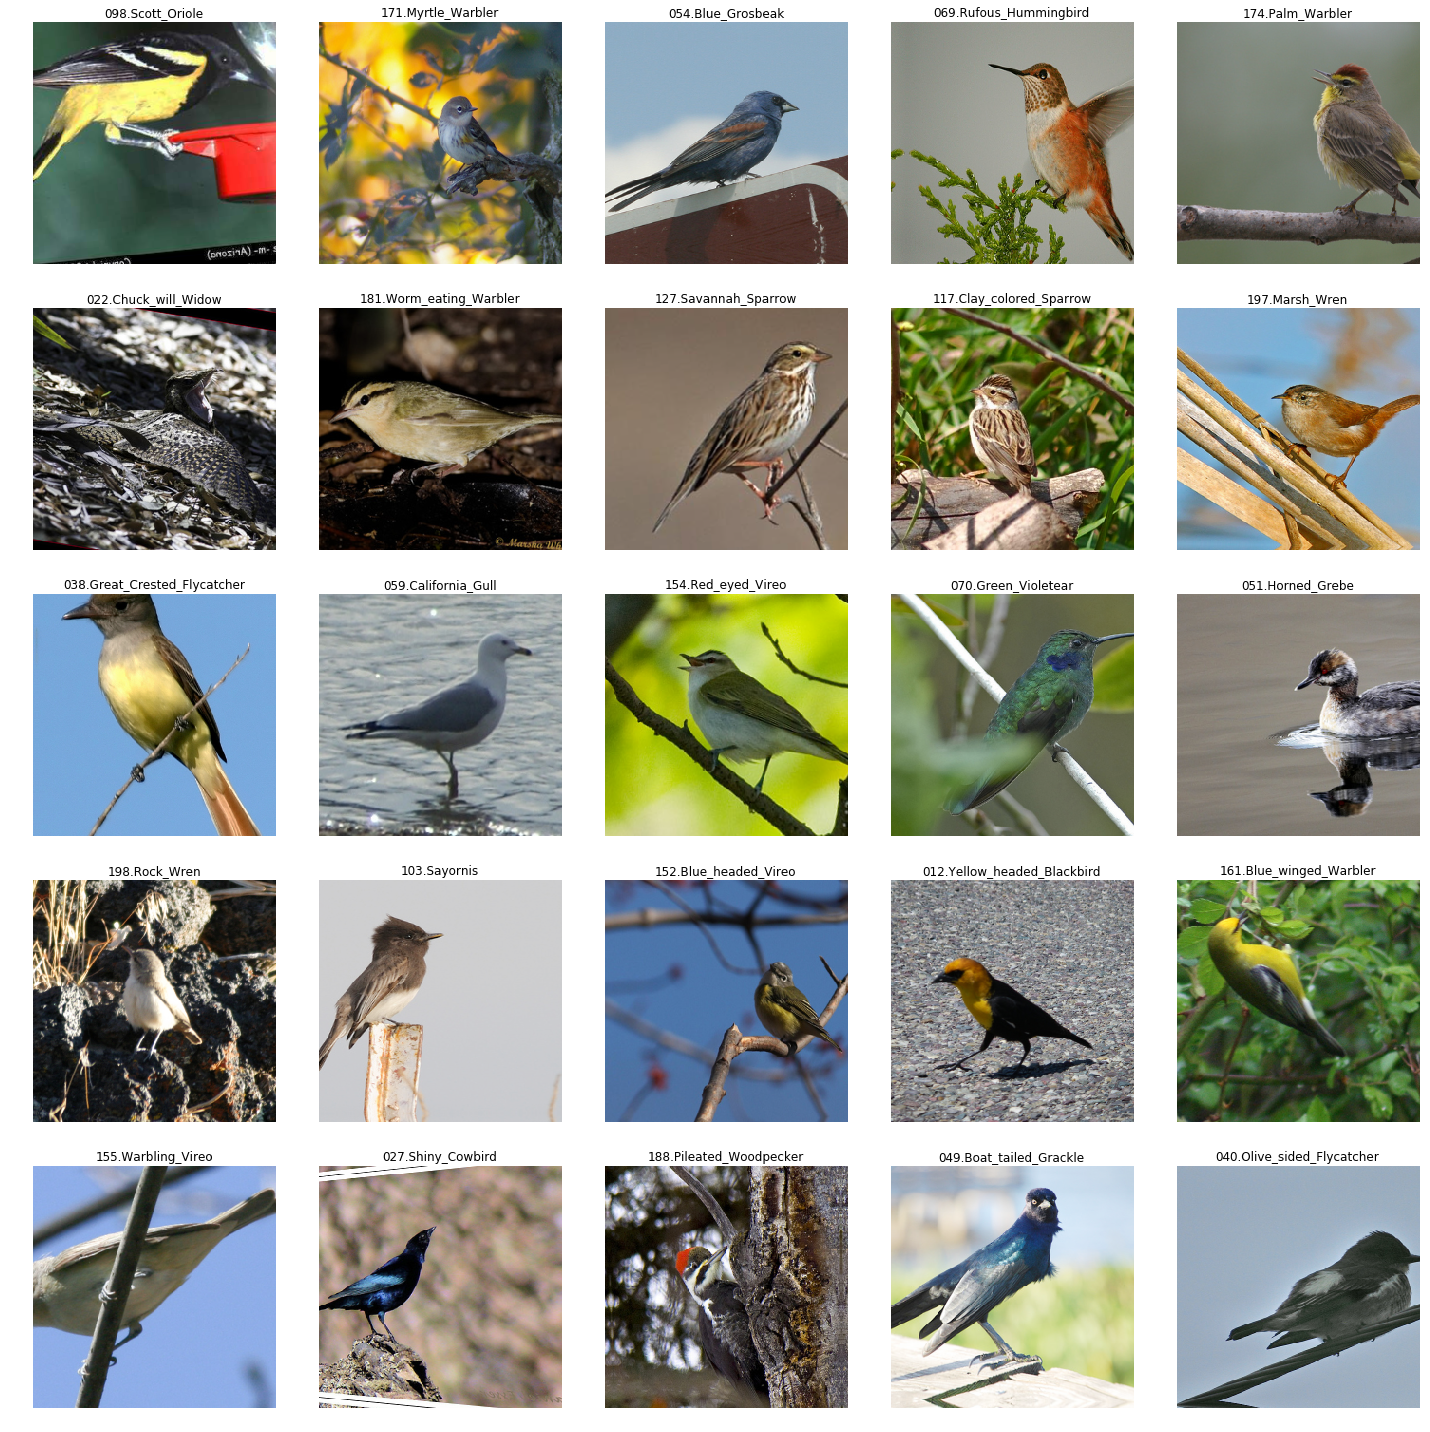

In [5]:
data.show_batch()

In [6]:
from torchvision import models
import torchvision
from Decoder import conv3x3,ConvRelu,DecoderBlock,DecoderBlockV2

In [7]:
class FeatureLoss(nn.Module):
    def __init__(self,):
        super().__init__()
        self.metric_names = ['aloss','bloss']
        self.aloss=CrossEntropyFlat()
#         self.bloss=nn.CosineSimilarity(dim=1, eps=1e-6)
    
    def forward(self, input, target):
        target=target.long()
        aloss=self.aloss(input[0],target)
        bloss=self.aloss(input[1],target)
#         bloss=torch.sigmoid(input[1])
#         bloss=bloss[range(len(target)),target].mean()
        loss=aloss+bloss
        outloss=[aloss,bloss]   
        self.metrics=dict(zip(self.metric_names,outloss))
        return loss

In [8]:
def newacc(input, target):
    return accuracy(input[0],target)


In [9]:
class UnetResnet34(nn.Module):
    def __init__(self,
                 num_classes=2,
                 num_filters=32,
                 pretrained=True,
                 is_deconv=False):
        """
        :param num_classes:
        :param num_filters:
        :param pretrained:
            False - no pre-trained network is used
            True  - encoder is pre-trained with resnet34
        :is_deconv:
            False: bilinear interpolation is used in decoder
            True: deconvolution is used in decoder
        """
        super().__init__()
        self.num_classes = num_classes

        self.mean = (0.485, 0.456, 0.406)
        self.std = (0.229, 0.224, 0.225)        
        
        self.pool = nn.MaxPool2d(2, 2)

        self.encoder = torchvision.models.resnet34(pretrained=pretrained)

        self.relu = nn.ReLU(inplace=True)

        self.conv1 = nn.Sequential(self.encoder.conv1,
                                   self.encoder.bn1,
                                   self.encoder.relu,
                                   self.pool)

        self.conv2 = self.encoder.layer1

        self.conv3 = self.encoder.layer2

        self.conv4 = self.encoder.layer3

        self.conv5 = self.encoder.layer4
        self.avgpool = self.encoder.avgpool
        self.fc=nn.Linear(in_features=512, out_features=200, bias=True)

        self.center = DecoderBlockV2(512, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec5 = DecoderBlockV2(512 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec4 = DecoderBlockV2(256 + num_filters * 8, num_filters * 8 * 2, num_filters * 8, is_deconv)
        self.dec3 = DecoderBlockV2(128 + num_filters * 8, num_filters * 4 * 2, num_filters * 2, is_deconv)
        self.dec2 = DecoderBlockV2(64 + num_filters * 2, num_filters * 2 * 2, num_filters * 2 * 2, is_deconv)
        self.dec1 = DecoderBlockV2(num_filters * 2 * 2, num_filters * 2 * 2, num_filters, is_deconv)
        self.dec0 = ConvRelu(num_filters, num_filters)
        self.final = nn.Conv2d(num_filters, num_classes, kernel_size=1)
#         self.trans = conv_layer(2,1,1,leaky=0.1)
        self.trans2 = conv_layer(2,3,1,leaky=0.1)
#         self.ReLU=nn.ReLU(inplace=True)

                
    def forward(self, x):
        conv1 = self.conv1(x)
        conv2 = self.conv2(conv1)
        conv3 = self.conv3(conv2)
        conv4 = self.conv4(conv3)
        conv5 = self.conv5(conv4)
#         print(conv5.shape)
        out1=self.avgpool(conv5)
        out1 = out1.reshape(out1.size(0), -1)
        out1=self.fc(out1)
        center = self.center(self.pool(conv5))
        dec5 = self.dec5(torch.cat([center, conv5], 1))
        dec4 = self.dec4(torch.cat([dec5, conv4], 1))
        dec3 = self.dec3(torch.cat([dec4, conv3], 1))
        dec2 = self.dec2(torch.cat([dec3, conv2], 1))
        dec1 = self.dec1(dec2)
        dec0 = self.dec0(dec1)
        x_out = self.final(dec0)
#         newx=self.trans(x_out)
#         print(newx.shape,x.shape)
#         x=x+newx[:,1:2,:]*x
#         x=x+newx*x
        newx=self.trans2(x_out)
#         x_out = torch.sigmoid(self.final(dec0))
#         x=x_out.expand_as(x)
#         x=x*x_out+x
        conv6 = self.conv1(newx)
        conv6 = self.conv2(conv6)
        conv6 = self.conv3(conv6)
        conv6 = self.conv4(conv6)
        conv6 = self.conv5(conv6)
        out2=self.avgpool(conv6)
        out2 = out2.reshape(out2.size(0), -1)
        out2=self.fc(out2)
        return out1,out2

In [10]:
gc.collect()
learn=None
model=None
learn=Learner(data,model=UnetResnet34(),loss_func=FeatureLoss(),metrics=newacc,callback_fns=LossMetrics).to_fp16()

In [252]:
# learn.load('unet_19')

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


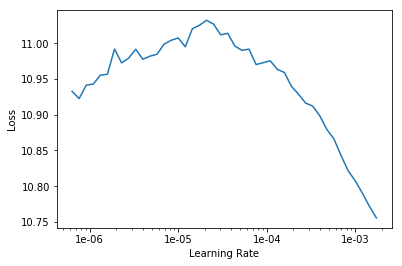

In [16]:
learn.lr_find()
learn.recorder.plot()

In [11]:
learn.fit_one_cycle(20,slice(1e-4),callbacks=[SaveModelCallback(learn, every='epoch', monitor='accuracy', name='unet2layer')])

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


In [12]:
from fastai.callbacks.hooks import *

In [23]:
i=np.random.randint(9431) #40
test=data.train_ds[i]
sz = list(test[0].shape[-2:])

In [24]:
xb,_ = data.one_item(test[0], detach=False, denorm=False)
xb=xb.float()

In [25]:
m =learn.model.eval().float()
layer1=m.final
with hook_output(layer1) as hook_a:
    preds = m(xb)

/home/staff/xin/miniconda3/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


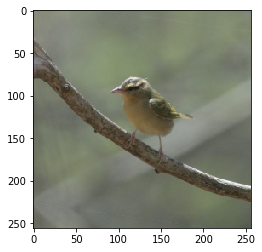

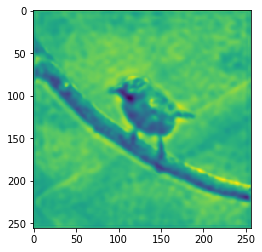

In [26]:
plt.imshow(test[0].data.numpy().transpose(1,2,0))
plt.show()
plt.imshow(hook_a.stored[0,1])

In [88]:
datalist=pd.read_csv('./CUB_200_2011/images.txt',header=None)
lockist=pd.read_csv('./CUB_200_2011/bounding_boxes.txt',header=None)

In [220]:
BOX_COLOR = (255, 0, 0)
TEXT_COLOR = (255, 255, 255)
import cv2
import torchvision.transforms as transforms
import PIL.Image as IMG
scaler = transforms.Resize((256, 256))
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
to_tensor = transforms.ToTensor()

def visualize_bbox(img, bbox, classname, color=BOX_COLOR, thickness=2):
#     x_min, y_min, w, h = bbox
    x_min, x_max, y_min, y_max = int(float(bbox[0])), int(float(bbox[2]))+int(float(bbox[0])), int(float(bbox[1])), int(float(bbox[3]))+int(float(bbox[1]))
    cv2.rectangle(img, (x_min, y_min), (x_max, y_max), color=color, thickness=thickness)
    class_name = classname
    ((text_width, text_height), _) = cv2.getTextSize(class_name, cv2.FONT_HERSHEY_SIMPLEX, 0.35, 1)    
    cv2.rectangle(img, (x_min, y_min - int(1.3 * text_height)), (x_min + text_width, y_min), BOX_COLOR, -1)
    cv2.putText(img, class_name, (x_min, y_min - int(0.3 * text_height)), cv2.FONT_HERSHEY_SIMPLEX, 0.35,TEXT_COLOR, lineType=cv2.LINE_AA)
    return img

def visualize(path,bbox,classname):
    img=io.imread(path)
    img = visualize_bbox(img, bbox,classname)
    fig,ax = plt.subplots()
    ax.imshow(img)
    
    ax.axis('off')   
    return img.shape

In [246]:
idx=np.random.randint(len(datalist))
classname=datalist.iloc[idx,0].split(' ')[1].split('/')[0].split('.')[1]
image='./CUB_200_2011/images/'+datalist.iloc[idx,0].split(' ')[1]
bbox=lockist.iloc[idx,0].split(' ')[1:]

In [247]:
imgten=normalize(to_tensor(scaler(IMG.open(image)))).unsqueeze(0).cuda()

In [248]:
m =learn.model.eval().float()
layer1=m.final
with hook_output(layer1) as hook_a:
    preds = m(imgten)

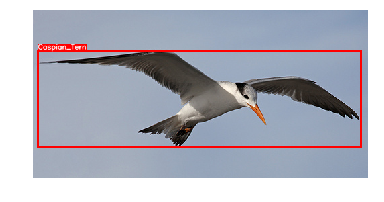

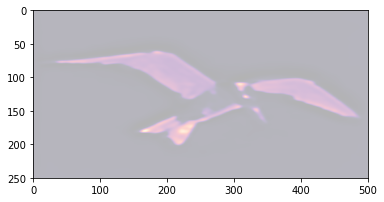

In [249]:
shape=visualize(image,bbox,classname)
plt.show()
# shape=visualize(image,bbox,classname)
plt.imshow(hook_a.stored[0,1],alpha=0.3, extent=(0,shape[1],shape[0],0), interpolation='bilinear', cmap='magma')

In [202]:
hook_a.stored[0,1].max()

tensor(2.8735, device='cuda:0')